# Making sentiment predictions over tweets dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a tweet is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian and regression

In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk

nltk.download('punkt')

import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# con = sqlite3.connect('../input/database.sqlite')
# messages = pd.read_sql_query("""SELECT Score, Summary FROM Reviews WHERE Score != 3""", con)

reviews = pd.read_csv('data/reviews_sent.csv', encoding = 'latin')
print(reviews.info())
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4649 entries, 0 to 4648
Data columns (total 3 columns):
Id          4649 non-null int64
Summary     4649 non-null object
Positive    4649 non-null int64
dtypes: int64(2), object(1)
memory usage: 109.1+ KB
None


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Carso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Id,Summary,Positive
0,1,Unacceptable Dog Food,0
1,2,Not as Advertised,0
2,3,"""Delight"" says it all",1
3,4,Cough Medicine,0
4,5,Great taffy,1


In [14]:
# Task 1: each student creates two rows of training data






In [15]:
y = reviews['Positive']
X = reviews['Summary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cleaning the data and convert text info to counts

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :
- Stemming
- Stop words removal
- Lowering
- Tokenization
- Pruning (numbers and punctuation)

In [22]:
stemmer = PorterStemmer()
count_vect = CountVectorizer()

from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)   # Resource 'tokenizers/punkt/english.pickle' not found
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

# replace each punctuation with a space
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set
corpus = []
for text in X_train:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
    
X_train_counts = count_vect.fit_transform(corpus)        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set
test_set = []
for text in X_test:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [17]:
prediction = dict()

## Applying Multinomial Naïve Bayes learning method

In [18]:
from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = multi.predict(X_test_tfidf)

<h2> Applying Decision Tree learning method</h2>

In [19]:
from sklearn.tree import DecisionTreeClassifier
clt = DecisionTreeClassifier()
clt.fit(X_train_tfidf, y_train)
prediction['clt'] = clt.predict(X_test_tfidf)

## Applying Logistic regression learning method

In [20]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Applying Support Vector Model

In [24]:
# Task 2: build a support vector model
from sklearn.svm import SVC

svc = SVC(C= 1.0, kernel='linear')
svc.fit(X_train_tfidf, y_train)

prediction['svc'] = svc.predict(X_test_tfidf)


## Applying Random Forest


In [27]:
# Task 3: run several random forest models and select the best one
from sklearn.ensemble import RandomForestClassifier

# play around with the setting for max_features
for i in range(1, 11):
    rfc2 = RandomForestClassifier(max_features=i, random_state=1)
    rfc2.fit(X_train_tfidf, y_train)
    pred2 = rfc2.predict(X_test_tfidf)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy_score(y_test, pred2)))

C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for 1 feature(s) equals 0.878494623655914
Accuracy for 2 feature(s) equals 0.8591397849462366
Accuracy for 3 feature(s) equals 0.8666666666666667


C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for 4 feature(s) equals 0.875268817204301
Accuracy for 5 feature(s) equals 0.8763440860215054
Accuracy for 6 feature(s) equals 0.8688172043010752


C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for 7 feature(s) equals 0.8817204301075269
Accuracy for 8 feature(s) equals 0.875268817204301
Accuracy for 9 feature(s) equals 0.8763440860215054
Accuracy for 10 feature(s) equals 0.8698924731182796


C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
rfc7 = RandomForestClassifier(max_features=7, random_state=1)
rfc7.fit(X_train_tfidf, y_train)
prediction['rfc7'] = rfc7.predict(X_test_tfidf)

C:\Users\Carso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Model Evaluation

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In first data cleaning, stop-words removal has been used, but the results were much worse. Reason for this result could be that when people want to speak about what is or is not good, they use many small words like "not" for instance, and these words will typically be tagged as stop-words, and will be removed. This is why in the end, it was decided to keep the stop-words. For those who would like to try it by themselves, I have let the stop-words removal as a comment in the cleaning part of the analysis.

In [43]:
# Tree model evaluation
y_pred_tree = clt.predict(X_test_tfidf)
print("Model evaluation for Tree Model:")
print(confusion_matrix(y_test, y_pred_tree))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
# model evaluation 2: Accuracy, sensitivity & specificty
print("Accuracy = %s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))

# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_tree))





# Task 4: add evaluation for Random forest

list(zip(X_train_tfidf, rfc7.feature_importances_))



Model evaluation for Tree Model:
[[ 98  55]
 [ 98 679]]
Accuracy = 0.8354838709677419
Sensitivity = 0.8738738738738738
Specificity = 0.6405228758169934
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       153
           1       0.93      0.87      0.90       777

    accuracy                           0.84       930
   macro avg       0.71      0.76      0.73       930
weighted avg       0.86      0.84      0.84       930



[(<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 4 stored elements in Compressed Sparse Row format>,
  0.0002806104158991092),
 (<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 11 stored elements in Compressed Sparse Row format>,
  2.7399588456295095e-05),
 (<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 3 stored elements in Compressed Sparse Row format>,
  0.0002840747376580567),
 (<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 7 stored elements in Compressed Sparse Row format>,
  0.00033212619827590825),
 (<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 3 stored elements in Compressed Sparse Row format>, 0.0),
 (<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 2 stored elements in Compressed Sparse Row format>,
  0.0007155127687250431),
 (<1x2272 sparse matrix of type '<class 'numpy.float64'>'
  	with 3 stored elements in Compressed Sparse Row format>,
  4.769218029099235e-06),
 (<1x2272

IndexError: list index out of range

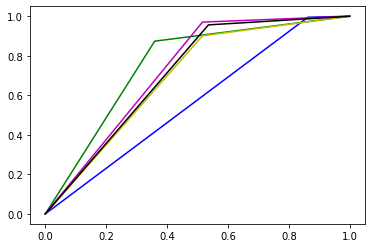

In [30]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results, although the AUC value for this method is not outstanding... 

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

# Import the tweets dataset
In this part, we will use the model we selected to generate prediction for other user comments, for example, users' comments on AUFootball Fanpage.

In [32]:
tweets = pd.read_csv('data/wetweets.csv', encoding = "latin")
tweets.head()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Donât get ready...stay ready!!pic.twitter.co...,"<p class=""TweetTextSize js-tweet-text tweet-te..."
2,AURobUSA,ðð¤ð¡ð¸ð« Â ð¯ Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle","<p class=""TweetTextSize js-tweet-text tweet-te..."
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...,"<p class=""TweetTextSize js-tweet-text tweet-te..."
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...,"<p class=""TweetTextSize js-tweet-text tweet-te..."


In [33]:
# convert the text info into tfidf matrix
corpus_2 = []
for text in tweets['text']:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus_2.append(text)
    
X_new_counts2 = count_vect.transform(corpus_2)
X_test_tfidf2 = tfidf_transformer.transform(X_new_counts2)

In [34]:
tweets['positive'] = clt.predict(X_test_tfidf2)
tweets['sentiment'] = ['positive' if x == 1 else 'negative' for x in tweets['positive']]

In [35]:
col = ['text', 'timestamp', 'sentiment']
tweets = tweets[col]

In [36]:
# convert string time to actual timestamp
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

# get week numbers within the year
tweets['week_number'] = [x.isocalendar()[1] for x in tweets['timestamp']]

In [37]:
# create a column for 'negative' and a column for 'positive'
df_sent = pd.get_dummies(tweets['sentiment'])
tweets = pd.concat([tweets,df_sent], axis=1)

In [38]:
tweets.head()

,text,timestamp,sentiment,week_number,negative,positive
0,#WarEagle #HookEmHorns #OUSucks,2019-08-15 23:51:47,negative,33,1,0
1,Donât get ready...stay ready!!pic.twitter.co...,2019-08-15 23:48:52,negative,33,1,0
2,"Thank you, I loved working on it! #WarEagle",2019-08-15 23:38:17,positive,33,0,1
3,Good. Looking. Picture. \r\n#WarEagle https://...,2019-08-15 23:35:40,positive,33,0,1
4,#Auburn admission applications for 2020 terms ...,2019-08-15 23:15:39,negative,33,1,0


In [39]:
table = pd.pivot_table(tweets,index=['week_number'],aggfunc=np.sum)
print(table)

             negative  positive
week_number                    
31              598.0     615.0
32             1034.0    1101.0
33              902.0     986.0
34             1062.0    1119.0
35             3330.0    3436.0
36             1828.0    1754.0
37             1459.0    1497.0
38             2076.0    2177.0
39             1970.0    2122.0
40             2232.0    2548.0
41              993.0    1404.0
42             1223.0    1495.0
43             1721.0    1885.0
44             1756.0    1648.0
45             1865.0    1883.0


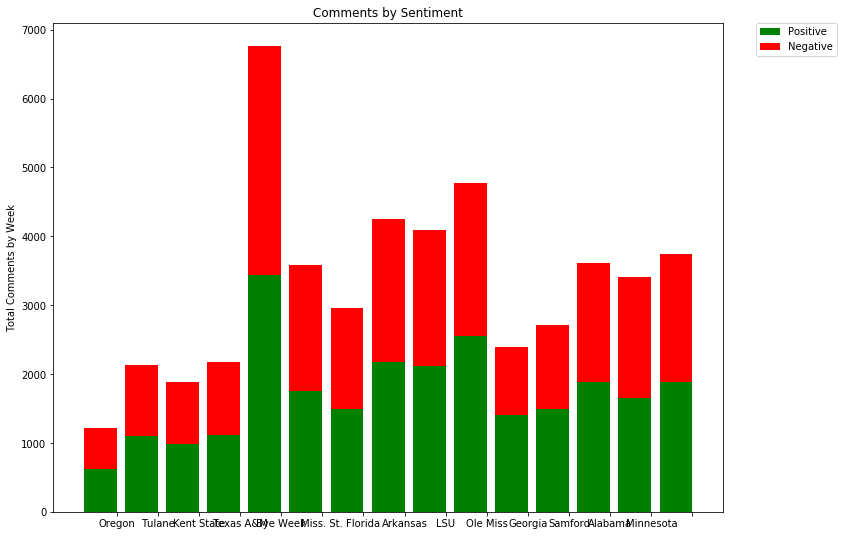

In [45]:
# Task 5: Change the week names to the correct opponent teams






pos = table['positive'].values
neg = table['negative'].values
week_number = table.index

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
width = 0.8

p1 = plt.bar(week_number, pos, width, color='green',tick_label = week_number)
p2 = plt.bar(week_number, neg, width, color='red', tick_label = week_number, bottom=pos)

plt.ylabel('Total Comments by Week')
plt.title('Comments by Sentiment')
plt.xticks(week_number + width/2., ('Oregon','Tulane','Kent State','Texas A&M','Bye Week','Miss. St.','Florida','Arkansas','LSU','Ole Miss', 'Georgia','Samford','Alabama','Minnesota'))
plt.legend((p1[0], p2[0]), ('Positive', 'Negative'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [41]:
# Task 6: briefly describe the plot

'Surprisingly, the bye week has the greatest volume of tweets. Maybe everybody is spending their time on their phones when they dont have any football to watch? Other than that, the tweets seem rather sporadic. Big games like LSU, Ole Miss, Alabama, and the bowl game with Minnesota seem to get rather high volumes of tweets which is to be expected. Total comments seem to trend upwards up until the ole miss game and then sharply decline but begin to rise again 


